# To run if on Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import shutil
import zipfile
import os

file_name = 'Dataset_TXA.zip'

# copying the dataset to the temporary workspace
print('Copying Dataset to temporary workspace...')
shutil.copyfile('drive/MyDrive/Dataset_TXA.zip', 'Dataset_TXA.zip')
print('Copied...')

# unzipping the dataset
path = 'Dataset'
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall(path)

#moving inside the Dataset folder
os.chdir(path)
os.getcwd()

Mounted at /content/drive
Copying Dataset to temporary workspace...
Copied...


'/content/Dataset'

In [2]:
!pip install swifter
!pip install wordcloud
!pip install gensim
!pip install transformers
!pip install spacy
!spacy download en_core_web_sm

# to remove the output of the installation
from IPython.display import clear_output
clear_output(wait=True)
print('Set up complete')

Set up complete


# Importing the Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import timeit
from collections import Counter

import requests
from bs4 import BeautifulSoup

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS

import torch
import swifter
from wordcloud import WordCloud
from transformers import AutoTokenizer, AutoModelForSequenceClassification

nltk.download('punkt')
stop_words = set(STOPWORDS)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
# cleaning different patterns
def clean_tokens(tokens):
    tokens = re.sub(r'[^\w\s]', '', tokens)
    tokens = re.sub(r'<.*?>', '', tokens) #removing HTMLS
    tokens = re.sub(r"\\", "", tokens) #removing \ character
    tokens = re.sub(r"\n", "", tokens)
    tokens = re.sub(r"http\S+", "", tokens) #removing HTTPS
    tokens = re.sub(r'\b\d+\b', '', tokens) #removing numbers
    
    return tokens.strip().lower()

In [5]:
#cleaning stopwords and words containing non alphanumeric characters
def remove_stop_words(column):
    return [[word for word in ls if (word not in stop_words) and word.isalpha()] for ls in column]

# Loading the Training Set

In [6]:
df = pd.read_csv("gr_training_set.csv")

In [7]:
df.tail(4)

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments,genre
899996,b9450d1c1f97f891c392b1105959b56e,16095092,e979c735276431915d089cfaf446d64f,3,This was a quick read for me. I have read a lo...,Fri Nov 16 22:09:49 -0800 2012,Sat Nov 17 23:38:58 -0800 2012,Sat Nov 17 00:00:00 -0800 2012,Fri Nov 16 00:00:00 -0800 2012,1,1,NaN
899997,b9450d1c1f97f891c392b1105959b56e,8430896,feb9fe6439f9fbba8a1cce36020ad977,4,** spoiler alert ** \n 3.5 stars. \n This book...,Tue Nov 13 05:38:24 -0800 2012,Tue Nov 13 23:29:17 -0800 2012,Tue Nov 13 00:00:00 -0800 2012,Tue Nov 13 00:00:00 -0800 2012,1,0,Young Adult
899998,b9450d1c1f97f891c392b1105959b56e,12275680,741e29369f70531bfffbd02add86f228,4,** spoiler alert ** \n Another fun read from M...,Mon Nov 12 05:42:30 -0800 2012,Tue Nov 13 22:32:05 -0800 2012,Tue Nov 13 00:00:00 -0800 2012,Mon Nov 12 00:00:00 -0800 2012,0,0,Mystery
899999,b9450d1c1f97f891c392b1105959b56e,17005,d55f3a967230940e75a314700caec9a5,3,** spoiler alert ** \n 3.5 stars \n I liked it...,Sun Nov 11 00:05:43 -0800 2012,Sun Nov 11 21:59:08 -0800 2012,Sun Nov 11 00:00:00 -0800 2012,Sun Nov 11 00:00:00 -0800 2012,0,0,Young Adult


# Checking Users' behaviour
If some users reviewed too many books and if the users reviewed the same books more than once

In [8]:
dist_user_reviews = sorted(
                            list(df.user_id.value_counts().items()),
                           key = lambda x: -x[1]) #sorting on count

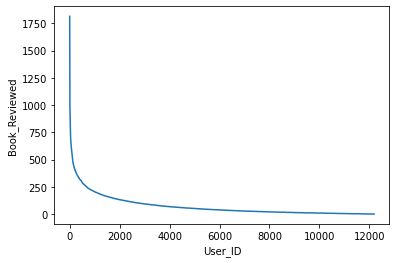

In [9]:
# conclusion: power law of a few users with lots of reviews
plt.plot([x[1] for x in dist_user_reviews])
plt.ylabel('Book_Reviewed')
plt.xlabel('User_ID')
plt.show()

In [10]:
book_per_user = df.groupby(['user_id', 'book_id']).count()['review_id']
book_per_user

user_id                           book_id 
000a1016fda6008d1edbba720ca00851  178476      1
                                  215643      1
                                  458034      1
                                  3863861     1
                                  6040871     1
                                             ..
ffff7cafdaf5196383cb2efca08fb6fe  27161826    1
                                  27272506    1
                                  28260587    1
                                  28954189    1
                                  32571395    1
Name: review_id, Length: 900000, dtype: int64

In [11]:
# no review of the same book
book_per_user.max()

1

# Balancing reviews per book
Sampling reviews pertaining to books with too many reviews

In [12]:
df['n_review_per_book'] = df.groupby('book_id')['book_id'].transform(len)

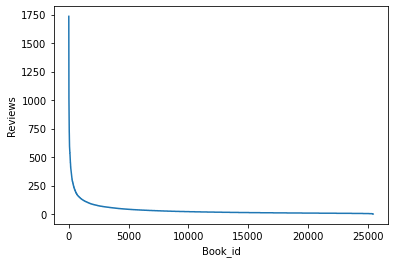

In [13]:
# too many reviews for some books, they need some balancing
reviews_x_book = [x[1] for x in sorted(list(set([(x, y) for x, y in df[['book_id', 'n_review_per_book']].values])),
                                       key = lambda x: -x[1])]
                                       
plt.plot(reviews_x_book)
plt.ylabel('Reviews')
plt.xlabel('Book_id')
plt.show()

In [14]:
#average number of reviews per book
average_rev = int(sum(reviews_x_book) / len(reviews_x_book) // 1)
average_rev

35

In [15]:
indexes_to_keep = df[df['n_review_per_book'] <= average_rev].index
index_sampled = df[df['n_review_per_book'] > average_rev].groupby('book_id').sample(average_rev).index

new_indexes = sorted(indexes_to_keep.tolist()+index_sampled.tolist())

In [16]:
df = df.loc[new_indexes].reset_index(drop=True)
len(df)

501745

# Dropping NaN genres

In [17]:
#Dropping NaN values
print(f"NaN values: {df.genre.isna().sum()}")
df.dropna(subset=['genre'], inplace=True)
print(f"NaN values: {df.genre.isna().sum()}")

NaN values: 71220
NaN values: 0


In [18]:
df_len = len(df)
print(f'New Dataset Length: {df_len}')

New Dataset Length: 430525


# Storing the new training set and cleaning RAM

In [19]:
rev = df[["review_text","genre", "rating", "book_id"]]
del df

# Balancing the genres

In [20]:
list(rev.genre.value_counts().items())[:10]

[('Romance', 110224),
 ('Fantasy', 99576),
 ('Young Adult', 63176),
 ('Fiction', 28783),
 ('Science Fiction', 19808),
 ('Mystery', 17766),
 ('Sequential Art', 17078),
 ('Historical', 12771),
 ('Horror', 9878),
 ('Classics', 7518)]

In [21]:
#genres with more than 2000 records
genres_to_keep = {genre:count for genre, count in rev.genre.value_counts().items() if count > 2000}

In [23]:
genres_to_keep

{'Romance': 110224,
 'Fantasy': 99576,
 'Young Adult': 63176,
 'Fiction': 28783,
 'Science Fiction': 19808,
 'Mystery': 17766,
 'Sequential Art': 17078,
 'Historical': 12771,
 'Horror': 9878,
 'Classics': 7518,
 'New Adult': 6915,
 'Nonfiction': 5093,
 'Dark': 4249,
 'Paranormal': 3903,
 'Childrens': 3302,
 'Thriller': 3197,
 'Erotica': 2838}

In [22]:
rev = rev[rev["genre"].isin(genres_to_keep)]
print(f"Removed rows: {df_len - len(rev)}")
print(f"Dataset len: {len(rev)}")

Removed rows: 14450
Dataset len: 416075


## Class Undersampling

In [24]:
n = 2500
msk = rev.groupby('genre')['genre'].transform(len) >= n
rev2 = pd.concat((rev[msk].groupby('genre').sample(n=n), rev[~msk]), ignore_index=True)

In [25]:
rev2.genre.value_counts()

Childrens          2500
New Adult          2500
Thriller           2500
Sequential Art     2500
Science Fiction    2500
Romance            2500
Paranormal         2500
Nonfiction         2500
Mystery            2500
Classics           2500
Horror             2500
Historical         2500
Fiction            2500
Fantasy            2500
Erotica            2500
Dark               2500
Young Adult        2500
Name: genre, dtype: int64

## Plotting Genres distribution

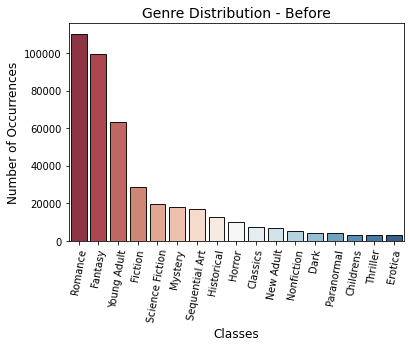

In [26]:
sns.barplot([x for x in genres_to_keep.keys()],
            [y for y in genres_to_keep.values()],
            alpha=0.9, palette="RdBu", edgecolor="black")

plt.title('Genre Distribution - Before',fontsize=14)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Classes', fontsize=12)
plt.xticks(rotation=80)
plt.show()

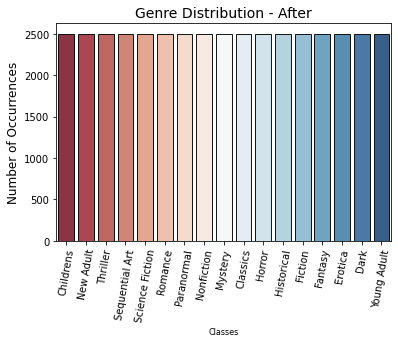

In [27]:
sns.barplot([x for x in rev2.genre.value_counts().index],
            [y for y in rev2.genre.value_counts().values],
            alpha=0.9, palette="RdBu", edgecolor="black")

plt.title('Genre Distribution - After',fontsize=14)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Classes', fontsize=8)
plt.xticks(rotation=80)
plt.show()

In [28]:
#cleaning review_text col
rev = rev2
rev.review_text = rev.review_text.swifter.apply(lambda x: clean_tokens(x))
rev.head()

Pandas Apply:   0%|          | 0/42500 [00:00<?, ?it/s]

,review_text,genre,rating,book_id
0,stellas great aunt louise is taking care of st...,Childrens,4,12860772
1,this was my favorite book when i was young i s...,Childrens,5,44186
2,recently discovered when clearing out a cupboa...,Childrens,4,385250
3,im late to the party on this one but happy to ...,Childrens,5,272343
4,my first jason reynolds book wont be my last,Childrens,5,28954126


### Tokeninzing Text

In [29]:
rev["tokenized_text"] = rev.review_text.swifter.apply(lambda x: word_tokenize(x))
rev.head()

Pandas Apply:   0%|          | 0/42500 [00:00<?, ?it/s]

,review_text,genre,rating,book_id,tokenized_text
0,stellas great aunt louise is taking care of st...,Childrens,4,12860772,"[stellas, great, aunt, louise, is, taking, car..."
1,this was my favorite book when i was young i s...,Childrens,5,44186,"[this, was, my, favorite, book, when, i, was, ..."
2,recently discovered when clearing out a cupboa...,Childrens,4,385250,"[recently, discovered, when, clearing, out, a,..."
3,im late to the party on this one but happy to ...,Childrens,5,272343,"[im, late, to, the, party, on, this, one, but,..."
4,my first jason reynolds book wont be my last,Childrens,5,28954126,"[my, first, jason, reynolds, book, wont, be, m..."


In [30]:
# Removing Stop Words
print(f"Token list len before: {len(rev.tokenized_text[0])}")
rev["fixed_tokenized_text"] = remove_stop_words(rev["tokenized_text"])
print(f"Token list len after: {len(rev.fixed_tokenized_text[0])}")

Token list len before: 221
Token list len after: 104


In [31]:
rev.head()

,review_text,genre,rating,book_id,tokenized_text,fixed_tokenized_text
0,stellas great aunt louise is taking care of st...,Childrens,4,12860772,"[stellas, great, aunt, louise, is, taking, car...","[stellas, great, aunt, louise, taking, care, s..."
1,this was my favorite book when i was young i s...,Childrens,5,44186,"[this, was, my, favorite, book, when, i, was, ...","[favorite, book, young, recommend, book, added..."
2,recently discovered when clearing out a cupboa...,Childrens,4,385250,"[recently, discovered, when, clearing, out, a,...","[recently, discovered, clearing, cupboard, let..."
3,im late to the party on this one but happy to ...,Childrens,5,272343,"[im, late, to, the, party, on, this, one, but,...","[im, late, party, happy, catch, having, read, ..."
4,my first jason reynolds book wont be my last,Childrens,5,28954126,"[my, first, jason, reynolds, book, wont, be, m...","[jason, reynolds, book, wont]"


### Extracting vocabulary 

In [ ]:
dict_count = dict(sorted(nltk.FreqDist([parola for testo in rev["fixed_tokenized_text"] for parola in testo]).items(), key=lambda x: x[1], reverse=True))

In [ ]:
dict_count_fixed = {k:v for k,v in dict_count.items() if v>5}
# dict_count_fixed

In [ ]:
vocabulary = set(dict_count_fixed.keys())
# vocabulary
len(vocabulary)

26037

# sentiment to skip

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [ ]:
rev["sentiment"] = rev["review_text"].swifter.apply(lambda x: sentiment_score(x))

# Spacy

In [ ]:
# !pip install spacy
# !spacy download en_core_web_sm

In [ ]:
import spacy

# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")

In [ ]:
doc = nlp(" ".join(rev.fixed_tokenized_text[1]))
print(doc[:100])

recommended katz avail free december


### Entities

In [ ]:
for entity in doc.ents:
    print(entity.text, entity.label_)

december DATE


In [ ]:
doc.ents

(december,)

In [ ]:
from spacy import displacy

displacy.render(doc, style="ent")

# WorldCloud

In [ ]:
def plot_cloud_rating(df, rating):
    review = rev[rev.rating == rating]["review_text"]
    
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(review.values[0])
    plt.figure(figsize=(15,6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [ ]:
review = rev[rev.rating == 1]["review_text"]
review[:5]

135    i had to force myself to make it through  page...
251    dnf around page  and skimmed the rest i just c...
411    cant believe its from the same guy who wrote c...
445    obviously enough im in the minority here but t...
465    i love kooky family stories as much as the nex...
Name: review_text, dtype: object

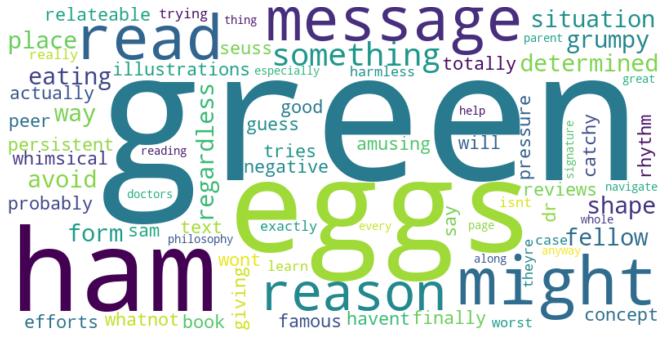

In [ ]:
plot_cloud_rating(rev, 5)

In [ ]:
def frequency_per_genre(df, genre):
    df_review = df[df.genre == genre]
    
    tokenized_text = word_tokenize(" ".join([el for el in df_review["review_text"]]))
    
    frequency_distribution = dict(sorted(nltk.FreqDist(
    [parola for parola in tokenized_text if parola not in stop_words and parola.isalpha()]).items(), 
                                     key=lambda x:x[1], 
                                     reverse= True))
    return frequency_distribution
    
def plot_cloud_genre(df, genre = None, freq_dist_new = None):
    if not freq_dist_new:
        freq_dist_new = frequency_per_genre(df, genre)
    
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(freq_dist_new)
    plt.figure(figsize=(15,6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

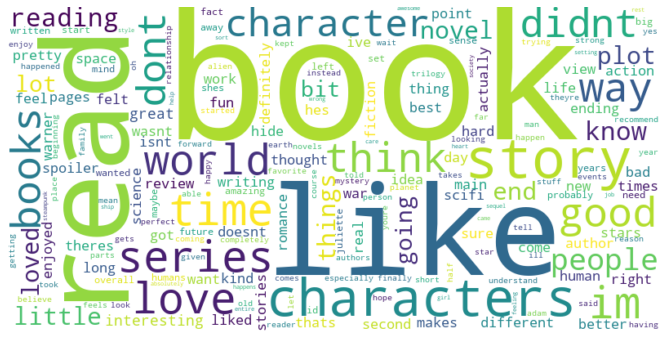

In [ ]:
plot_cloud_genre(rev, "Science Fiction")

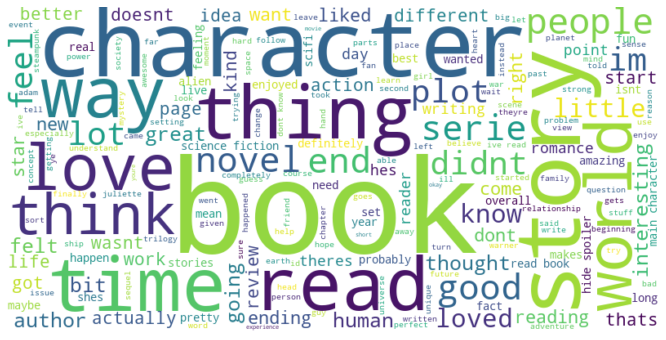

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_text(" ".join([parola for lista in rev[rev.genre == "Science Fiction"]["fixed_tokenized_text"] for parola in lista]))
plt.figure(figsize=(15,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

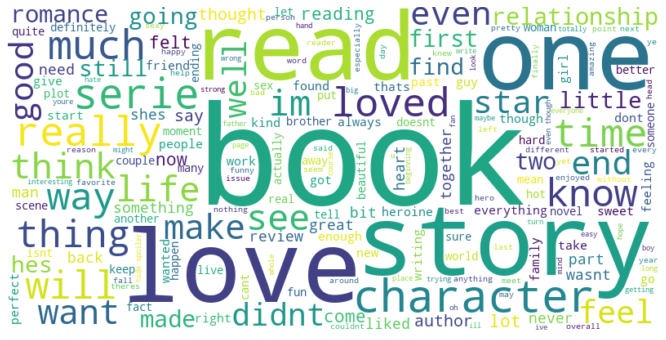

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_text(" ".join([el for el in rev[rev.genre == "Romance"]["review_text"]]))
plt.figure(figsize=(15,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
list((parola for lista in rev[rev.genre == "Science Fiction"]["fixed_tokenized_text"] for parola in lista))

['special',
 'book',
 'started',
 'slow',
 'middle',
 'started',
 'interesting',
 'blew',
 'mind',
 'love',
 'good',
 'science',
 'fiction',
 'pushes',
 'thinking',
 'things',
 'hugo',
 'winner',
 'translated',
 'original',
 'chinese',
 'interesting',
 'different',
 'way',
 'things',
 'ive',
 'read',
 'instance',
 'intermixing',
 'chinese',
 'revolutionary',
 'history',
 'kept',
 'accusing',
 'people',
 'reactionaries',
 'book',
 'science',
 'aliens',
 'science',
 'described',
 'book',
 'impressive',
 'book',
 'grounded',
 'physics',
 'pretty',
 'accurate',
 'far',
 'tell',
 'view',
 'spoilerthough',
 'got',
 'folding',
 'protons',
 'dimensions',
 'think',
 'making',
 'stuff',
 'interesting',
 'think',
 'happen',
 'seti',
 'stations',
 'received',
 'message',
 'person',
 'monitoring',
 'answering',
 'signal',
 'disillusioned',
 'book',
 'bit',
 'dark',
 'like',
 'think',
 'human',
 'reaction',
 'discovering',
 'alien',
 'civilization',
 'hostile',
 'like',
 'enders',
 'game',
 'band',
